## Process ERA5 regions ##

For each DNO region, process the daily max wind gust and total precipitation, 
to visualise alongside the fault data for each DNO region.

In [1]:
import os
import sys
import glob

import numpy as np
import iris
import cftime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry
import cartopy.io.shapereader as shpreader

# Specific imports
from tqdm import tqdm
from typing import List, Tuple, Dict, Any, Optional
from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress
from mpl_toolkits.axes_grid1 import make_axes_locatable

# standard libraries
from pathlib import Path

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the directory in which the files are stored
files_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Dec/data_stream-oper_stepType-max.nc"

# if the files path exists, load the data
if os.path.exists(files_path):
    print(f"Loading file: {files_path}")
    cube = iris.load_cube(files_path, "fg10")

Loading file: /home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Dec/data_stream-oper_stepType-max.nc


/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/netcdf/loader.py:233: IrisLoadWarning: NetCDF variable `expver` is a variable length type of kind <class 'str'> thus the total data size cannot be known in advance. This may affect the lazy loading of the data.
  warnings.warn(msg, category=iris.warnings.IrisLoadWarning)


In [3]:
cube.coord('time')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/common/mixin.py:203: FutureWarning: You are using legacy date precision for Iris units - max precision is seconds. In future, Iris will use microsecond precision - available since cf-units version 3.3 - which may affect core behaviour. To opt-in to the new behaviour, set `iris.FUTURE.date_microseconds = True`.
  warnings.warn(message, category=FutureWarning)


<DimCoord: time / (seconds since 1970-01-01)  [2025-01-01 00:00:00, ...]  shape(744,)>

In [4]:
shapefile_paths = {
    "DNO": Path("/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp")
}

In [5]:
# Read in NESO's DNO shapefile with geopandas
dno_shapes = gpd.read_file(shapefile_paths["DNO"])

In [6]:
# print the head of the df
print("DNO Shapes DataFrame:")
print(dno_shapes.head())

DNO Shapes DataFrame:
                                            geometry
0  MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...
1  POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...
2  POLYGON ((-0.24419 51.48844, -0.24509 51.48926...
3  MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....
4  POLYGON ((-1.95899 53.21664, -1.95676 53.21383...


In [7]:
# Expanded DNO Shapes DataFrame
expanded_dno_shapes = pd.DataFrame({
    "ID": [10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 18, 20],
    "Name": ["_A", "_B", "_C", "_D", "_E", "_F", "_G", "_P", "_J", "_K", "_L", "_M", "_N", "_H"],
    "DNO": ["UKPN", "NGED", "UKPN", "SPEN", "NGED", "NPG", "ENWL", "SSEN", "UKPN", "NGED", "NGED", "NPG", "SPEN", "SSEN"],
    "Area": [
        "East England", "East Midlands", "London", "North Wales, Merseyside and Cheshire",
        "West Midlands", "North East England", "North West England", "North Scotland",
        "South East England", "South Wales", "South West England", "Yorkshire",
        "South and Central Scotland", "Southern England"
    ],
    "DNO_Full": [
        "UK Power Networks", "National Grid Electricity Distribution", "UK Power Networks",
        "SP Energy Networks", "National Grid Electricity Distribution", "Northern Powergrid",
        "Electricity North West", "Scottish and Southern Electricity Networks", "UK Power Networks",
        "National Grid Electricity Distribution", "National Grid Electricity Distribution",
        "Northern Powergrid", "SP Energy Networks", "Scottish and Southern Electricity Networks"
    ],
})

# Print the expanded DataFrame
print("Expanded DNO Shapes DataFrame:")
print(expanded_dno_shapes)

# add these columns to the dno_shapes GeoDataFrame
for col in expanded_dno_shapes.columns:
    if col not in dno_shapes.columns:
        dno_shapes[col] = expanded_dno_shapes[col].values

Expanded DNO Shapes DataFrame:
    ID Name   DNO                                  Area  \
0   10   _A  UKPN                          East England   
1   11   _B  NGED                         East Midlands   
2   12   _C  UKPN                                London   
3   13   _D  SPEN  North Wales, Merseyside and Cheshire   
4   14   _E  NGED                         West Midlands   
5   15   _F   NPG                    North East England   
6   16   _G  ENWL                    North West England   
7   17   _P  SSEN                        North Scotland   
8   19   _J  UKPN                    South East England   
9   21   _K  NGED                           South Wales   
10  22   _L  NGED                    South West England   
11  23   _M   NPG                             Yorkshire   
12  18   _N  SPEN            South and Central Scotland   
13  20   _H  SSEN                      Southern England   

                                      DNO_Full  
0                            UK Po

In [8]:
dno_shapes.head()

,geometry,ID,Name,DNO,Area,DNO_Full
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...",10,_A,UKPN,East England,UK Power Networks
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...",11,_B,NGED,East Midlands,National Grid Electricity Distribution
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926...",12,_C,UKPN,London,UK Power Networks
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....",13,_D,SPEN,"North Wales, Merseyside and Cheshire",SP Energy Networks
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383...",14,_E,NGED,West Midlands,National Grid Electricity Distribution


Text(119.83491205934631, 0.5, 'Latitude')

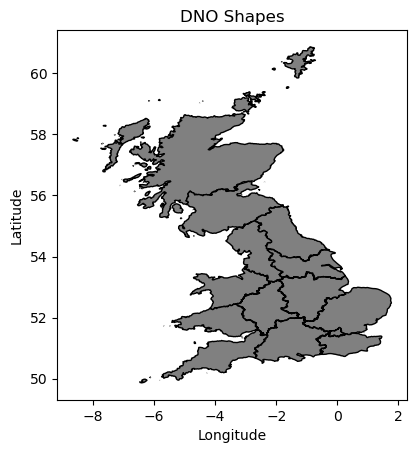

In [9]:
# Try plotting north west england first
dno_shapes.plot(
    color='grey',
    edgecolor='black',
    linewidth=1,
)
plt.title("DNO Shapes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

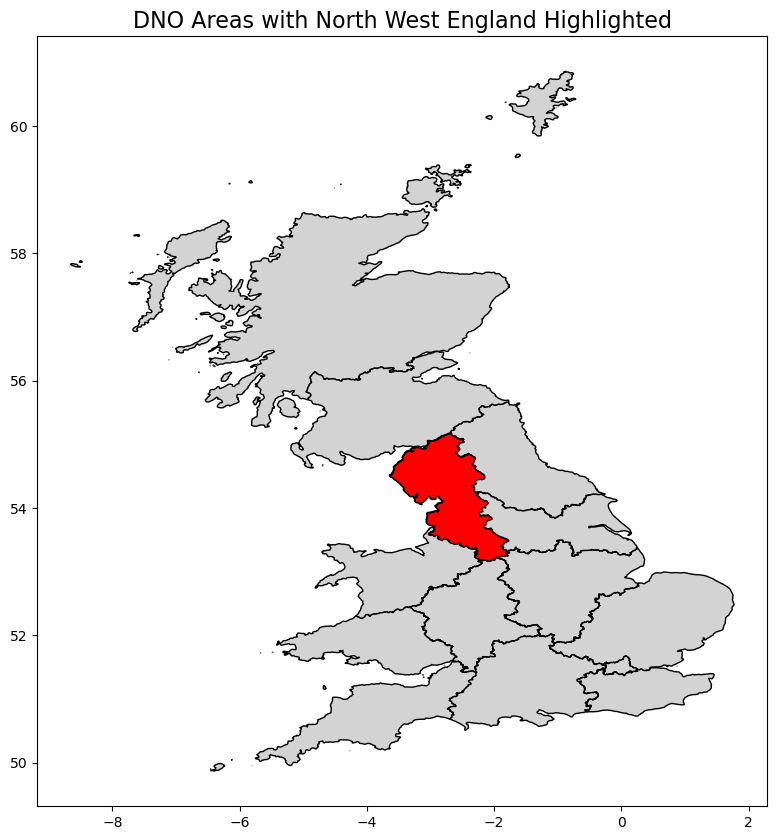

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter the GeoDataFrame for "North West England"
north_west_england = dno_shapes[dno_shapes["DNO"] == "ENWL"]

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
dno_shapes.plot(ax=ax, color="lightgrey", edgecolor="black")  # Plot all areas in light grey
north_west_england.plot(ax=ax, color="red", edgecolor="black")  # Highlight North West England in red

# Add title and labels
ax.set_title("DNO Areas with North West England Highlighted", fontsize=16)
plt.show()

In [11]:
%%time

# Set up the lons and lats
lons = cube.coord('longitude').points
lats = cube.coord('latitude').points

# extract the time points
time_points = cube.coord('time').points

# Set up the x, y
x, y = lons, lats

# extract the values of the cube
values_fg10 = cube.data

# # print the lons and lats
# print(f"Longitude points: {x}")
# print(f"Latitude points: {y}")
# # Set up the time points
# print(f"Time points: {time_points}")

CPU times: user 451 ms, sys: 117 ms, total: 568 ms
Wall time: 1.12 s


In [12]:
values_fg10

masked_array(
  data=[[[ 5.832562 ,  6.2349057,  6.518109 , ..., 17.580608 ,
          17.911663 , 18.180218 ],
         [ 4.6059995,  5.013226 ,  5.4233823, ..., 17.291546 ,
          17.56303  , 17.833538 ],
         [ 3.2983823,  3.7466245,  4.2446713, ..., 17.476116 ,
          17.647015 , 17.832561 ],
         ...,
         [18.842327 , 18.192913 , 17.445843 , ...,  7.589398 ,
           6.7397885,  6.6733823],
         [21.536663 , 21.246624 , 20.708538 , ...,  7.0952573,
           6.855023 ,  6.5434995],
         [23.620647 , 23.573772 , 23.136272 , ...,  6.959515 ,
           6.808148 ,  5.75932  ]],

        [[ 6.1335783,  6.4704924,  6.702914 , ..., 17.114046 ,
          17.480257 , 17.816195 ],
         [ 4.910922 ,  5.2517424,  5.594516 , ..., 16.812288 ,
          17.151155 , 17.491976 ],
         [ 3.3445158,  3.815219 ,  4.3035   , ..., 16.865023 ,
          17.056429 , 17.26053  ],
         ...,
         [19.23221  , 18.829866 , 18.3826   , ...,  7.754672 ,
           

In [18]:
import shapely.geometry

# Set up an empty dataframe with time_points as the index
dataframe_full = pd.DataFrame(index=(time_points))

# print the head of the dataframe full
print("DataFrame Full:")
print(dataframe_full.head())

# sys.exit()

# Loop over the rows in dno_shapes and extract time series for each DNO area
for index, row in tqdm(dno_shapes.iterrows(), total=len(dno_shapes)):
    # if index > 0:
    #     print("MAsk matrix this DNO")
    #     print(mask_matrix_this_dno)

    #     # print the number of non-zero values in the mask matrix
    #     print(f"Number of non-zero values in mask matrix for DNO {row['DNO']}: {np.count_nonzero(mask_matrix_this_dno)}")

    #     # print the number of zero values in the mask matrix
    #     print(f"Number of zero values in mask matrix for DNO {row['DNO']}: {np.size(mask_matrix_this_dno) - np.count_nonzero(mask_matrix_this_dno)}")

    #     # print the shape of the mask matrix
    #     print(f"Shape of mask matrix for DNO {row['DNO']}: {mask_matrix_this_dno.shape}")

    #     # Reshape the mask matrix into a time series by finding the max value at each time point
    #     time_series_max = np.max(mask_matrix_this_dno, axis=(1, 2))

    #     # Print the resulting time series shape
    #     print(f"Shape of time series: {time_series_max.shape}")

    #     # pritn the time series max values
    #     print(f"Time series max values for DNO {row['DNO']}: {time_series_max}")

    #     sys.exit("Skipping all but the first DNO for now, as this is a test run.")

    mask_matrix_this_dno = np.zeros((len(time_points), len(lats), len(lons)))

    for l in range(len(lats)):
        for j in range(len(lons)):
            point = shapely.geometry.Point(lons[j], lats[l])
            if row.geometry.contains(point):
                # Extract the time series for this point
                time_series_this_point = values_fg10[:, l, j]
                # Add the time series to the mask matrix
                mask_matrix_this_dno[:, l, j] = time_series_this_point

    # Reshape the mask matrix into a time series by finding the max value at each time point
    time_series_max = np.max(mask_matrix_this_dno, axis=(1, 2))
    # Add the time series to the dataframe
    dataframe_full[row['Area']] = time_series_max


DataFrame Full:
Empty DataFrame
Columns: []
Index: [1735689600, 1735693200, 1735696800, 1735700400, 1735704000]


100%|██████████| 14/14 [00:09<00:00,  1.54it/s]


In [19]:
dataframe_full.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
1735689600,21.790569,22.408733,20.229046,28.179241,21.928265,18.558147,18.694866,23.394085,22.347210,23.442913,20.486858,21.567913,20.033733,20.811077
1735693200,21.978304,22.712679,20.181429,28.451937,21.692171,18.090609,23.522249,23.335726,22.374788,23.245882,20.948030,22.240023,19.907015,21.140413
1735696800,22.127405,26.467249,19.950647,26.727991,21.581507,17.827600,25.434046,22.613733,22.144007,23.651819,21.429163,22.724085,19.141077,21.442835
1735700400,22.102224,22.977224,19.935232,26.342459,22.049490,17.006521,19.739920,22.535818,21.965506,24.385427,21.887381,22.745779,19.057302,21.730154
1735704000,21.453869,22.574963,20.183361,25.779064,22.900158,16.528088,21.873791,22.356213,22.116955,26.324963,22.396252,22.924572,19.617931,22.530041


In [20]:
# print the statistics of the dataframe
print("DataFrame Full Statistics:")
print(dataframe_full.describe())

DataFrame Full Statistics:
       East England  East Midlands      London  \
count    744.000000     744.000000  744.000000   
mean      10.544734      10.049373    7.681281   
std        5.105902       4.815721    5.281354   
min        2.870171       2.067924    1.587949   
25%        6.712028       6.439429    3.785991   
50%        8.970361       9.227954    5.883409   
75%       13.039875      12.199191    9.371973   
max       28.169748      29.761381   24.483469   

       North Wales, Merseyside and Cheshire  West Midlands  \
count                            744.000000     744.000000   
mean                              11.409827       8.834709   
std                                5.251432       4.836341   
min                                2.353966       2.431005   
25%                                7.400197       5.186902   
50%                               10.652082       7.502181   
75%                               14.231668      11.105107   
max                       

In [21]:
# convert the index to datetime
# valid_time:units = "seconds since 1970-01-01" ;
dataframe_full.index = pd.to_datetime(dataframe_full.index, unit='s', origin='1970-01-01')

In [23]:
dataframe_full.tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-01-31 19:00:00,6.835136,3.936698,3.004081,3.841972,4.395683,2.839042,2.624198,10.308768,7.116386,4.113456,5.100761,2.643730,3.498222,5.225761
2025-01-31 20:00:00,6.569185,3.937349,3.416841,3.094575,3.616060,3.576997,2.535982,11.650240,6.335786,3.653169,5.135591,2.968599,3.794771,5.193208
2025-01-31 21:00:00,6.140099,3.560997,4.144981,2.353966,3.193810,3.798302,3.395958,13.399864,6.879356,3.443810,5.037560,2.861778,4.207481,5.270958
2025-01-31 22:00:00,6.523525,2.941494,4.355556,2.790126,2.716884,4.554775,3.754970,14.096766,7.962978,3.302822,5.001064,2.080165,4.902431,5.319423
2025-01-31 23:00:00,6.511625,2.795805,4.010649,3.433501,2.592680,5.108305,4.269438,15.434477,8.598539,3.625883,4.863188,2.333891,5.613188,5.195219


In [24]:
# Maximum 10 metre wind gust

# Set up the directory in which to save this
output_dir = Path("/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs")

# Set up the fname
fname_this = "max_10m_wind_gust_timeseries_dno_areas.csv"

# if the full path does not exist, then save it
if not os.path.exists(os.path.join(output_dir, fname_this)):
    print(f"Saving dataframe to {os.path.join(output_dir, fname_this)}")
    dataframe_full.to_csv(os.path.join(output_dir, fname_this))

Saving dataframe to /home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/max_10m_wind_gust_timeseries_dno_areas.csv


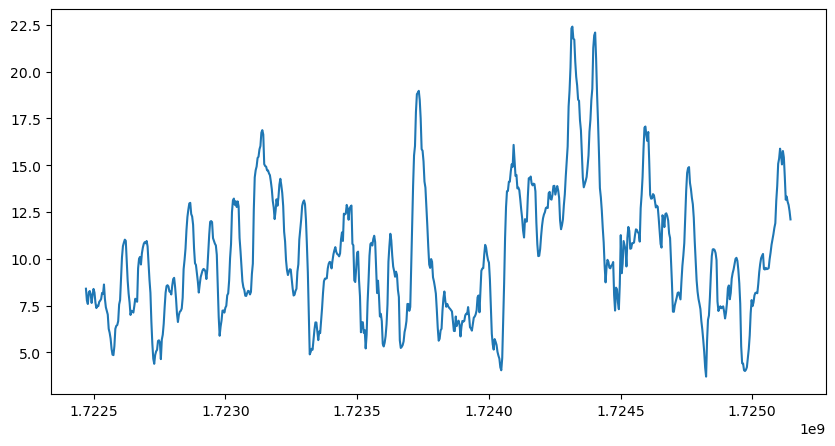

In [ ]:
# plot the time series max
plt.figure(figsize=(10, 5))

plt.plot(time_points, time_series_max, label=f"DNO {row['DNO']}")